<a href="https://colab.research.google.com/github/pachterlab/BI-BE-CS-183-2023/blob/main/HW5/Problem5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2022-2023: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 5 (Midterm) Problem 5**

For this problem you will be exploring various models which can be used to describe count data i.e. the gene-count matrices we use in single-cell.

Single-cell gene counts, which describe stochastically sampled, discrete measurements of UMI counts, are often modeled as being generated from a negative binomial (or Gamma-Poisson) distribution. However, there is a common assumption that droplet-based methods for single-cell RNA seq incur an overabundance of zeros (more zero counts) than would be predicted by random sampling. Thus it is also common to see single-cell data modeled with zero-inflated negative binomials (the ZINB distribution, with an extra parameter for the probability of zero counts).

You will explore how these assumptions and models fit to real datasets.

In [1]:
#To run a code cell, select the cell and hit Command/Ctrl+Enter or click the run/play symbol
#Click Insert --> Code Cell or the '+ Code' option to insert a new code cell

In [2]:
#Click Insert --> Text Cell or the '+ Text' option to insert a cell for text as below

In [3]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

Text here for descriptions, explanations, etc

##**Import data and install packages**

In [4]:
!pip --quiet install anndata

In [5]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn

import anndata

from scipy import optimize
from scipy.special import gammaln
from scipy.special import psi
from scipy.special import factorial
from scipy.optimize import fmin_l_bfgs_b as optim

In [6]:
# ! allows you to run commands in the command line, as you would in your normal terminal/command line interface

In [7]:
# Download control sample from indrops platform
# File format is h5ad

import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

download_file('10.22002/xsret-sb590','.gz')


/tmp/ipykernel_11951/3748164775.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pbar = tnrange(int(total_length/1024), unit="B")


  0%|          | 0/19383 [00:00<?, ?B/s]

'xsret-sb590.gz'

In [8]:
!gunzip *.gz
!mv xsret-sb590 Klein.h5ad


In [9]:
indrops = anndata.read('Klein.h5ad')

In [10]:
indrops

AnnData object with n_obs × n_vars = 953 × 25435
    obs: 'total_counts'
    var: 'empirical_mean', 'empirical_variance', 'empirical_zero_fraction', 'ml_mean', 'genewise_dispersion', 'global_zero_fraction', 'genewise_zero_fraction', 'scaled_count_mean', 'poisson_zero_fraction'
    uns: 'global_dispersion', 'name'

Use the function below for b). 


In [82]:
# X = numpy array of the data (e.g. 1D array with all the counts for one gene)
# initial params is a numpy array representing the initial values of
# size and prob parameters
# Returns: Dict with 'r' and 'p' fits
def fit_nbinom(X, initial_params=None):
    ''' This code is adapted from https://github.com/gokceneraslan/fit_nbinom
    '''
    infinitesimal = np.finfo(float).eps

    def log_likelihood(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        # MLE estimate based on the formula on Wikipedia:
        # http://en.wikipedia.org/wiki/Negative_binomial_distribution#Maximum_likelihood_estimation
        result = np.sum(gammaln(X + r)) \
            - np.sum(np.log(factorial(X))) \
            - N * (gammaln(r)) \
            + N * r * np.log(p) \
            + np.sum(X * np.log(1 - (p if p < 1 else 1 - infinitesimal)))

        return -result

    if initial_params is None:
        # reasonable initial values (from fitdistr function in R)
        m = np.mean(X)
        v = np.var(X)
        size = (m ** 2) / (v-m) if v > m else 10

        # convert mu/size parameterization to prob/size
        p0 = size / ((size + m) if size + m != 0 else 1)
        r0 = size
        initial_params = np.array([r0, p0])

    bounds = [(infinitesimal, None), (infinitesimal, 1)]
    optimres = optim(log_likelihood,
                     x0=initial_params,
                     args=(X,),
                     approx_grad=1,
                     bounds=bounds)

    params = optimres[0]
    return {'r': params[0], 'p': params[1]}

## **Read in data for analysis**

**The dataset**

Following an analysis perfomed in [Svensson et al. 2020](https://www.nature.com/articles/s41587-019-0379-5)  we will be analyzing negative control data made by the indrops platform. This negative control was made by adding RNA directly to fluid of microfluidic devices, so that each droplet generated has identical RNA content. Thus we can get a more rigorous sense of the zero counts of genes per droplet (and by proxy per cell) by this single-cell technology. This also allows for analysis of whether zero counts of genes are due to technical limitations or biological variation in cells.

**The Count matrix**

This matrix is 953 droplets by 25,435 genes, from [Klein et al. 2015](https://www.sciencedirect.com/science/article/pii/S0092867415005000?via%3Dihub). Total RNA (to mimic the amount of RNA in a cell, per droplet) and RNA samples at known concentrations are spiked-in to the microfluidic fluid, encapsulated by each droplet.

<center><img src="https://drive.google.com/uc?export=view&id=1mem7kVfkkIw0RmF8uc6ez7Flz1MEL8-t" alt="EMFigure" width="300" height="300"><center>

 


In [55]:
#Get gene count matrix
X = indrops.X.todense()
X.shape

(953, 25435)

## **Problem 5 (40 points)** 

The Poisson distribution expresses the probability of some $x$ number of events occurring in a fixed interval of time/space, with these events occuring at a known constant mean rate $\lambda$ (and independently of time since the last event).

The Poisson model is
\begin{align}
f(x; \lambda)= \Pr(X{=}x)= \frac{\lambda^x e^{-\lambda}}{x!}.
\end{align}

The negative binomial (NB) distribution describes the probability of seeing $x$ failures until some $r$ successes have occurred, with $p$ denoting the probability of success. 'Successes' can be thought of read counts here i.e the event that a read is a count for a given gene.

The NB model ($\text{NB}
(r,p)$) is
\begin{align}
f(x;r,p)\equiv \Pr(X=x)={\binom {x+r-1}{r-1}}(1-p)^{x}p^{r}
\end{align}

The Poisson distribution can be written as special case of the NB where $ \operatorname {Poisson} (\lambda )=\lim _{r\to \infty }\operatorname {NB} \left(r,{\frac {\lambda }{r+\lambda }}\right)$, with $p ={\frac {\lambda }{r+\lambda }}$.


Note: We can also denote $r,p$ as $\mu,\phi$ where $\mu$ represent the mean and $\phi$ represents the dispersion parameter. Here $p = \dfrac{r}{r + \mu}$ and $r = \dfrac{1}{\phi}$.
This convention is also common in the single-cell literature.

### **a) Plot mean versus variance of expression for all genes (across all cells) and comment on what trends you notice between the two (e.g. overdispersion etc). (5 points)**

In [50]:
X = np.array(X)

In [51]:
means = np.mean(X, axis=0)
sigs = np.var(X, axis=0)

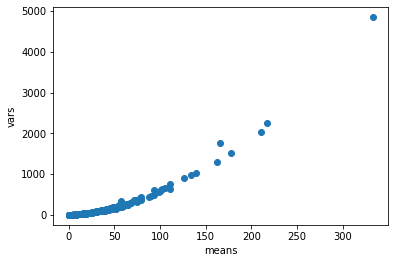

In [52]:
plt.scatter(means, sigs)
plt.xlabel("means")
plt.ylabel("vars")
plt.show()

There is definitely overdispersion, given that the points don't lie on a straight line and we see the variance increase as mean increases.

### **b) Fit Poisson and NB models for the first 100 genes. (10 points)**

Fit and save the parameters for these two models for the first 100 genes $g$.

For the Poisson models we can use the MLE estimate for $\lambda$ which is $\dfrac{1}{n}\sum_{i=1}^n x_{i,g}$.

For the NB $r \text{ and } p$ cannot (concurrently) be derived analytically. You can use the **fit_nbinom(X)** function defined above to obtain $r \text{ and } p$ fits for each gene.

**Report the parameter fits for the first 10 genes.**

In [83]:
from tqdm import tqdm

In [84]:
g = 100
# ngenes = X.shape[1]
ngenes = 100
poissons = np.zeros(ngenes)
nbs = np.zeros((ngenes, 2))

for g in tqdm(range(ngenes)):
    expression = X[:, g]

    poissons[g] = np.mean(expression)

    nb_params = fit_nbinom(expression)

    nbs[g] = [nb_params['r'], nb_params['p']]


100%|██████████| 100/100 [00:03<00:00, 28.94it/s]


In [85]:
poissons[:10]

array([0.50682056, 0.16579224, 1.02098632, 0.19727178, 0.16789088,
       0.72612804, 0.17208815, 0.03567681, 0.08079748, 0.13536201])

In [86]:
nbs[:10]

array([[ 6.24370217,  0.92492273],
       [ 9.99999953,  0.98369116],
       [53.46618462,  0.9812619 ],
       [ 9.99997955,  0.98065445],
       [ 9.99998048,  0.98348813],
       [25.74259854,  0.97256663],
       [ 1.5870269 ,  0.9022016 ],
       [ 9.99999953,  0.996445  ],
       [ 9.99998112,  0.991985  ],
       [ 9.99999954,  0.98664458]])

### **c) Perform a likelihood ratio test, and calculate the resulting p-value, between these two models (for a single gene), and comment on the implications of these outputs.**

We will be testing whether the added parameters of the NB improve the fit of the model to the data versus the Poisson model (which is a nested version of the NB), or not (if both models are equal i.e. $H_0$). Thus the test is  
\begin{align}
H_0 : r = ∞ \\
H_1: r < ∞.
\end{align}

For some gene $g$ we can calculate the log-likelihood for both models given parameter fits, and take the ratio of those likelihoods (which is the difference between the log-likelihoods).




The log-likelihood ratio value $2log(\dfrac{L_{NB}}{L_{Poisson}})$ (denoted `ratio' in the text) asymptotically approaches the chi-squared $χ^2$ distribution (in this case for a degree of freedom (df) of 1, the difference in the dfs of the models) if the null hypothesis ($H_0$) is true. Thus the cdf of the $χ^2$ distribution can be used to calculate a p-value given this ratio term (using [stats.chi2.cdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html)). 

A cdf() function evaluated as some value $x$ (i.e. cdf($x$)) is the probability that variable $X$ will be $\leq$ the value $x$. A p-value is 1-cdf($x$), or the probability of observing a value as or more extreme than the one observed ($x$).

**1 - cdf(ratio) will produce the p-value, where cdf() is the $χ^2$ cumulative distribution function.**

For the NB model the likelihood (for gene $g$) is:
$
\begin{align}
L^{(g)}(r,p)=\prod _{i=1}^{N}f(x_{i,g};r,p)
\end{align}$

And the log-likelihood:
$
\begin{align}
\ell^{(g)} (r,p)=\sum _{i=1}^{N}\ln(\Gamma (x_{i,g}+r))-\sum _{i=1}^{N}\ln(x_{i,g}!)-N\ln(\Gamma (r))+\sum _{i=1}^{N}x_{i,g}\ln(1-p)+Nr\ln(p).
\end{align}$ where Gamma can be calculated with [gammaln](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammaln.html).


For the Poisson model the likelihood (for gene $g$) is:
\begin{align}
L^{(g)}(\lambda ) =\prod _{i=1}^{n}f(x_{i,g}\mid \lambda ).
\end{align}

And the log-likelihood:
\begin{align}
\ell^{(g)} (\lambda )= -n\lambda +\left(\sum _{i=1}^{n}x_{i,g}\right)\ln(\lambda )-\sum _{i=1}^{n}\ln(x_{i,g}!).
\end{align}


**Explicitly calculate and report the log-likelihood ratio for the *seventh gene only (python index 6)*. Additionally report the p-value for this ratio (using the chi-squared cdf) and comment on what this value means in terms of the null and the alternative hypothesis.**

Note: It is common practice to treat p-values less than .05 as significant (we can reject the null hypothesis). This cutoff is the likelihood of rejecting the null when it’s actually true i.e. how much error you are willing to tolerate.

In [69]:
from scipy.special import gammaln, factorial
from scipy.stats import chi2

In [115]:
def nb_llike(r, p, data, idx):
    n = len(data)
    gam_sumr = np.sum(gammaln(data[:, idx] + r))
    factorial_sum = np.sum(np.log(factorial(data[:, idx])))
    n_gamma = gammaln(r)
    sum_ln = np.sum(data[:, idx] * np.log(1-p))
    nln = n * r * np.log(p)
    return gam_sumr - factorial_sum - n_gamma + sum_ln + nln

def pllike(lam, data, idx):
    n = len(data)
    sumx = np.sum(data[:, idx])
    factorial_sum = fact_sum = np.sum(np.log(factorial(data[:, idx])))
    return -n * lam + sumx * np.log(lam) - factorial_sum

In [116]:
r, p = nbs[6]
lam = poissons[6]
nbllike = nb_llike(r, p, X, 6)
poisllike = pllike(lam, X, 6)

In [125]:
ratio = 2 * nbllike / poisllike

In [126]:
p_val = 1 - chi2.cdf(ratio, 1)

In [128]:
print(f"pvalue: {p_val}, ratio: {ratio}")

pvalue: 0.11726054684185883, ratio: 2.4535347283174658


Cannot reject the null hypothesis given p=0.11 and not < 0.05

### **d) Derive the expression for the probability of zero counts (given an NB model), and calculate the expected zero-fraction (zero probability) for the first 100 genes. (10 points)**

Show that $P(0|\mu,\phi) = (\dfrac{\phi^{-1}}{\mu+\phi^{-1}})^{\phi^{-1}} $ (with P representing the NB distribution). Use the definitions of $\mu,\phi$ given in the main Problem 5 description. Then calculate these probabilities (i.e. zero-fractions) for the first 100 genes.

**In the code cell or in an uploaded image show your work to derive $P(0|\mu,\phi)$. Then report the zero-fractions for the first 10 genes.**

We know from above that $r = \frac{1}{\phi}$ and $p = \frac{r}{r + \mu}$.

From the definition of NB, we have $\begin{align}
f(x;r,p)\equiv \Pr(X=x)={\binom {x+r-1}{r-1}}(1-p)^{x}p^{r}
\end{align}$

Substituting in X=0 gives us:
\begin{align}
\Pr(X=0)={\binom {r-1}{r-1}}(1-p)^{0}p^{r}
\end{align}

Or:
\begin{align}
\Pr(X=0)=p^{r}
\end{align}

Substituting in the definitions above for p gives us:
\begin{align}
\Pr(X=0)=(\frac{r}{r + \mu})^r
\end{align}

But we know that $r = \phi^{-1}$

This gives us:
\begin{align}
\Pr(X=0)=(\frac{\phi^{-1}}{\phi^{-1} + \mu})^{\phi^{-1}}
\end{align}

As desired

In [144]:
zero_probs = np.zeros(100)
zero_fracs = np.zeros(100)
i = 0
for mu, phi in nbs:
    # From above, r = phi^-1, so the output from nbs should already be phi^-1
    zero_prob = (phi/(mu+phi))**phi
    zero_frac = np.mean(X[:, i] == 0)
    zero_probs[i] = zero_prob
    zero_fracs[i] = zero_frac
    i += 1


In [146]:
zero_fracs[:10]

array([0.61175236, 0.84260231, 0.36935992, 0.818468  , 0.84260231,
       0.48583421, 0.85099685, 0.96432319, 0.92130115, 0.86988458])

In [147]:
zero_probs[:10]

array([0.1504659 , 0.09315375, 0.01943078, 0.09358026, 0.09318233,
       0.03986885, 0.40026219, 0.091392  , 0.09200299, 0.09274166])

### **e) Generate a residual plot of the (Observed - Expected) zero-fractions versus mean expression per gene, and qualitatively comment on how similar or different the predicted values are. (5 points)**

Compare the probabilities in d) to the actual fraction of droplets with zero counts per gene (the observed zero-fractions).


**Generate the residual plot with all 100 genes.**

Text(0, 0.5, 'resids')

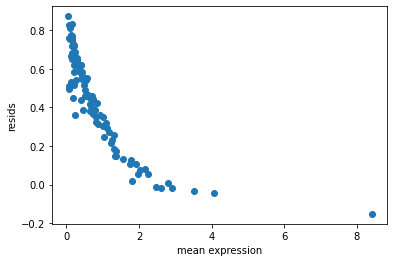

In [150]:
resids = zero_fracs - zero_probs
plt.scatter(means[:100], resids)
plt.xlabel("mean expression")
plt.ylabel("resids")